# Libraries

In [1]:
import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

import seaborn as sns

# Add the ../src directory to the Python path
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

from src import adjust_column_names

# Data Import

In [2]:
source_data = pd.read_csv(
    os.path.join('..', 'data', 'insurance_data_sample.csv'),
    sep=',',
    encoding='utf-8',
    parse_dates=['Date'],
    dtype={'Phone': str})

# Preprocessing

In [3]:
prep_data = source_data.copy()

## Adjust column names

In [4]:
prep_data = adjust_column_names(prep_data)

## Calculate date features

In [159]:
prep_data.loc[:, 'yyyymm'] = prep_data.loc[:, 'date'].dt.strftime('%Y%m')

# Analysis

## Cluster analysis

* There are 2 clusters for annual_income. The boundary can be where annual_income_log = 1.
* The data points where price_usd_log < 9 are outliers. Only 6 of them exist.

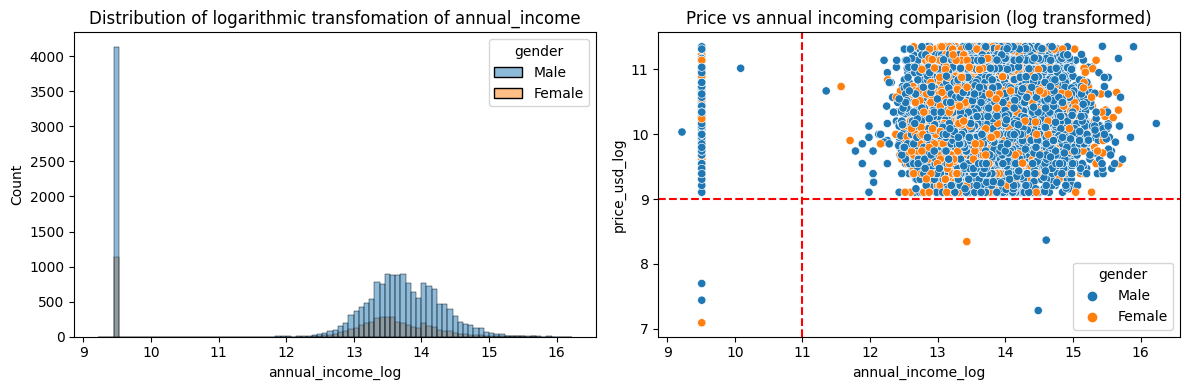

In [47]:
df = prep_data.copy()
df.loc[:, 'annual_income_log'] = np.log(df.loc[:, 'annual_income'] + 1)
df.loc[:, 'price_usd_log'] = np.log(df.loc[:, 'price_usd'] + 1)

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
g = sns.histplot(df, x='annual_income_log', hue='gender', ax=axs[0])
g.set_title('Distribution of logarithmic transfomation of annual_income')

g = sns.scatterplot(
    df,
    x='annual_income_log',
    y='price_usd_log',
    hue='gender',
    ax=axs[1])
g.set_title('Price vs annual incoming comparision (log transformed)')

g.axvline(11, color='red', linestyle='--')
g.axhline(9, color='red', linestyle='--')

plt.tight_layout()

In [37]:
# set segment feature
ix = df\
    .query('annual_income_log <= 11')\
    .query('price_usd_log >= 9')\
    .index
prep_data.loc[ix, 'segment'] = 'segment 1'

ix = df\
    .query('annual_income_log > 11')\
    .query('price_usd_log >= 9')\
    .index
prep_data.loc[ix, 'segment'] = 'segment 2'

ix = df\
    .query('price_usd_log < 9')\
    .index
prep_data.loc[ix, 'segment'] = 'outlier'

prep_data.loc[:, 'segment'].value_counts(dropna=False)

segment
segment 2    18628
segment 1     5272
outlier          6
Name: count, dtype: int64

In [44]:
prep_data\
    .query('segment == "outlier"')\
    .loc[:, 'price_usd']

13946    1200
13949    4200
13996    1450
14010    1700
14020    2200
14185    4300
Name: price_usd, dtype: int64

## Correlation analysis

* There is positive correlation between amount_paid_for_insurance vs price_usd. Probably, insurance payment is calculated based on price_usd field.
* There is no gender impact.

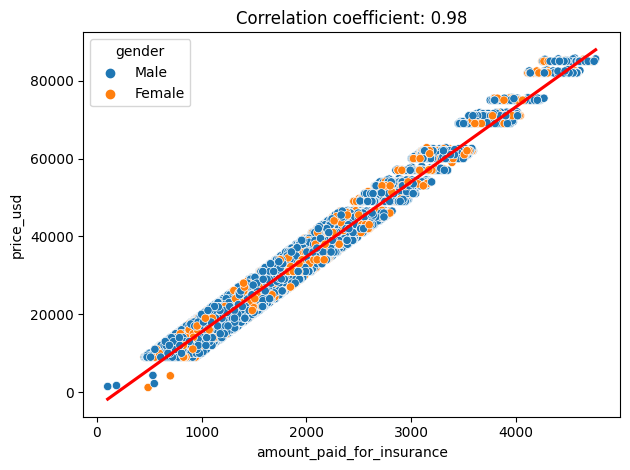

In [66]:
g = sns.regplot(
    prep_data,
    x='amount_paid_for_insurance',
    y='price_usd',
    ci=None,
    line_kws={'color': 'red'},
    scatter=False)

corr_coeff = prep_data\
    .loc[:, ['amount_paid_for_insurance', 'price_usd']]\
    .corr()\
    .iloc[0, 1]\
    .round(2)

g = sns.scatterplot(
    prep_data,
    x='amount_paid_for_insurance',
    y='price_usd',
    hue='gender')

g.set_title(f'Correlation coefficient: {corr_coeff}')

plt.tight_layout()

## Distribution analysis

**do the different segments have different cars in terms of price_usd?**
* In Riga, wealthy customers have similar price_usd with non-wealth ones. In all other cities, wealthy customers use higher price_usd cars with non-wealth ones.
* Outliers in Liepeja have very low price_usd cars but they have very high annual_income.

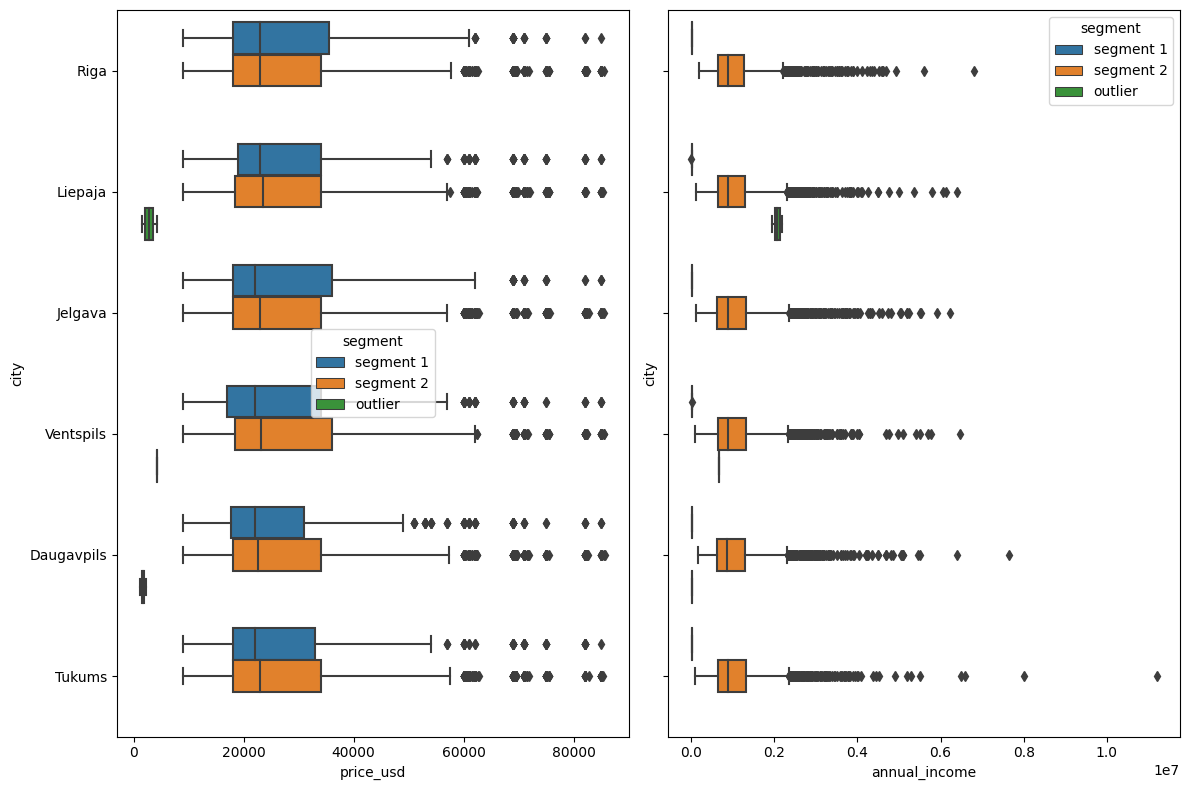

In [73]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 8), sharey=True)

g = sns.boxplot(
    prep_data,
    y='city',
    x='price_usd',
    hue='segment',
    ax=axs[0])

g = sns.boxplot(
    prep_data,
    y='city',
    x='annual_income',
    hue='segment',
    ax=axs[1])

plt.tight_layout()

## Claim amount analysis

compare the body types of the cars that women use vs. men use

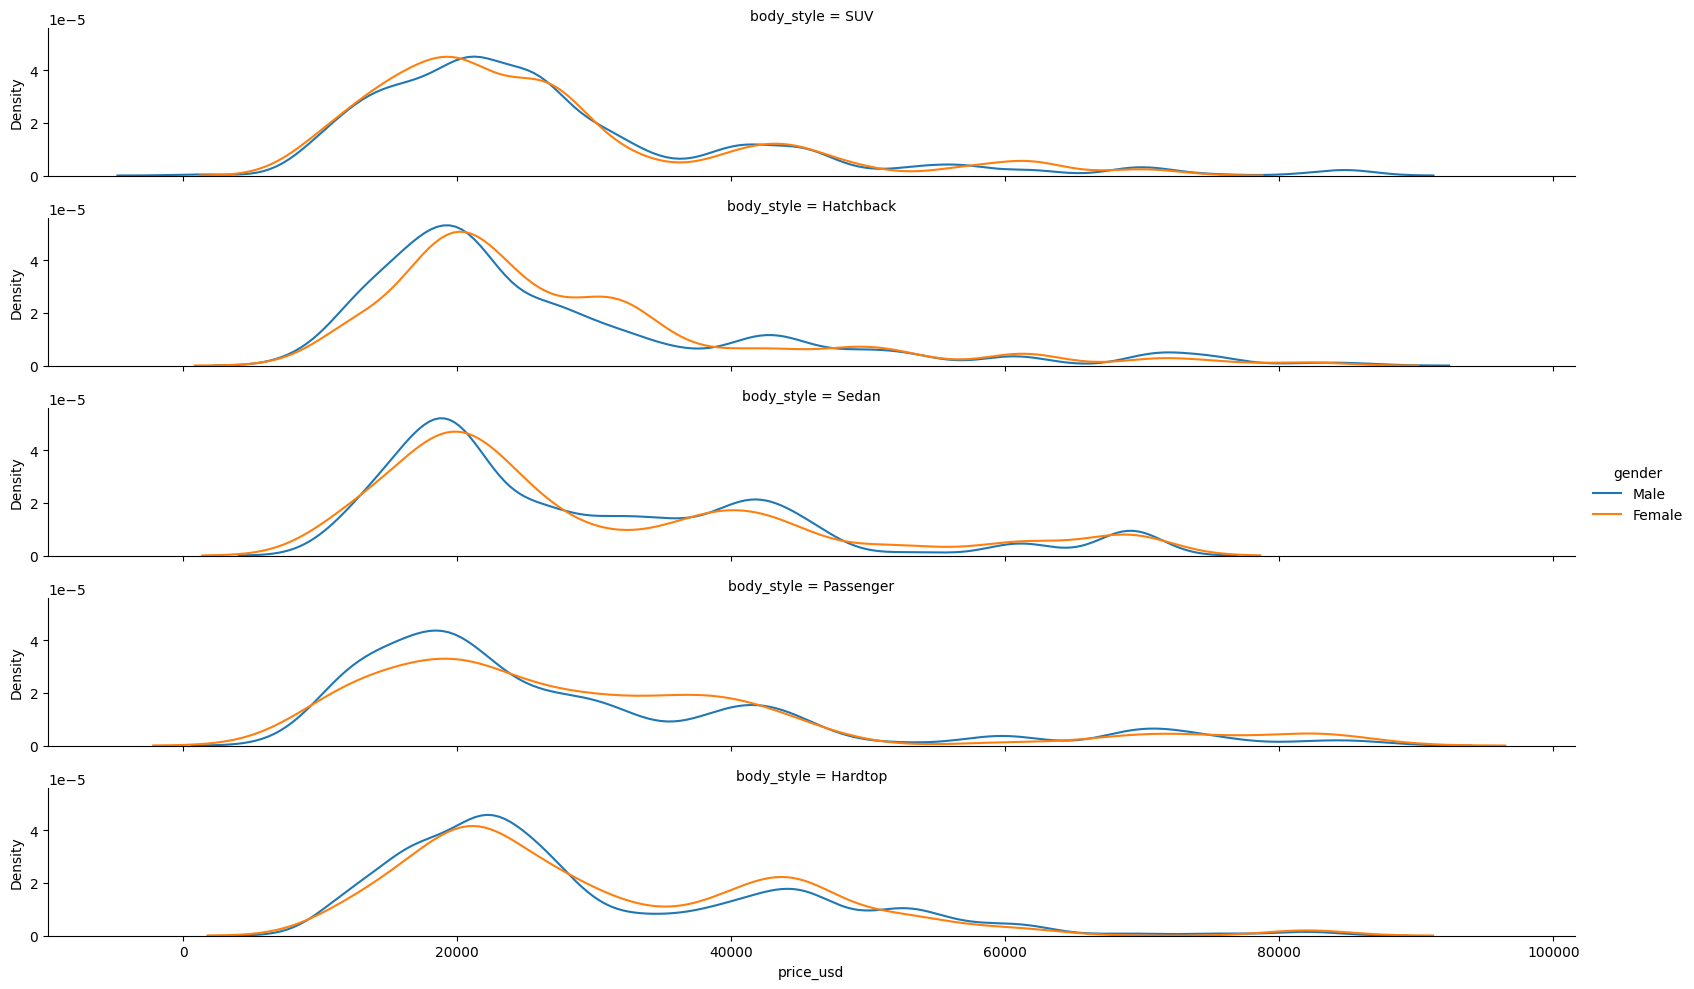

In [100]:
g = sns.FacetGrid(
    prep_data.query('claim_amount > 0'),
    row='body_style',
    hue='gender',
    aspect=8,
    height=2)

# Draw the densities in a few steps
g.map(sns.kdeplot, 'price_usd',
      bw_adjust=.5, clip_on=False,
      fill=False, alpha=1, linewidth=1.5)

g.add_legend()

**which type of car brings more cost to the insurance company?**

* female that use passenger have more claims.
* mans have higher claim ratio with hatchback and suv cars.

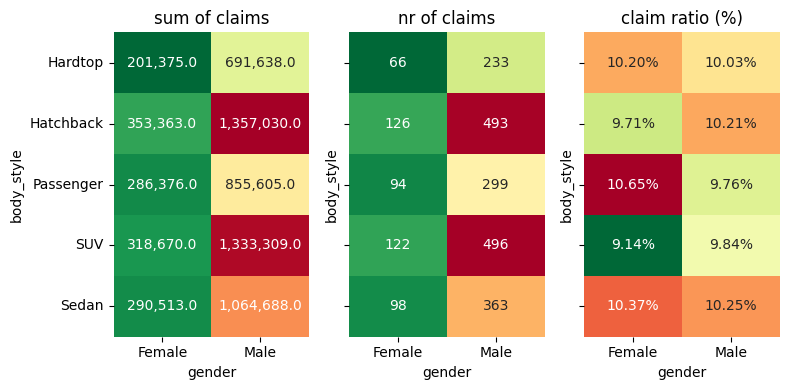

In [147]:
df = prep_data.query('claim_amount > 0').copy()
df_2 = df\
    .groupby(['body_style', 'gender'])\
    .agg(
        sum_of_claims=pd.NamedAgg('claim_amount', 'sum'),
        nr_of_claims=pd.NamedAgg('car_id', 'count'))\
    .reset_index()

df_3 = prep_data.copy()
df_3 = df_3\
    .groupby(['body_style', 'gender'])\
    .agg(
        nr_of_cars=pd.NamedAgg('car_id', 'count'))\
    .reset_index()

df_4 = df_2.merge(
    right=df_3,
    left_on=['body_style', 'gender'],
    right_on=['body_style', 'gender'],
    how='outer')

df_4.loc[:, 'claim_ratio'] = df_4.loc[:, 'nr_of_claims'] / df_4.loc[:, 'nr_of_cars']

fig, axs = plt.subplots(ncols=3, figsize=(8, 4), sharey=True)

df_5 = pd.pivot_table(
    df_4,
    index='body_style',
    columns='gender',
    values='sum_of_claims',
    aggfunc='mean')

sns.heatmap(
    df_5,
    annot=True,
    cmap='RdYlGn_r',
    ax=axs[0],
    cbar=False,
    fmt=',.1f')\
    .set_title('sum of claims')

df_7 = pd.pivot_table(
    df_4,
    index='body_style',
    columns='gender',
    values='nr_of_claims',
    aggfunc='mean')
sns.heatmap(
    df_7,
    annot=True,
    cmap='RdYlGn_r',
    ax=axs[1],
    cbar=False,
    fmt='.0f')\
    .set_title('nr of claims')

df_6 = pd.pivot_table(
    df_4,
    index='body_style',
    columns='gender',
    values='claim_ratio',
    aggfunc='mean')
sns.heatmap(
    df_6,
    annot=True,
    cmap='RdYlGn_r',
    ax=axs[2],
    cbar=False,
    fmt='.2%')\
    .set_title('claim ratio (%)')

plt.tight_layout()

**who makes accident more ? the ones who have better car or the ones who have cheaper car ?**
* the ones who have 10k-45k making more accident than 45k+.
* both male and female are distributed similarly.

Text(0.5, 1.0, 'Distribution of claims w.r.t price_usd')

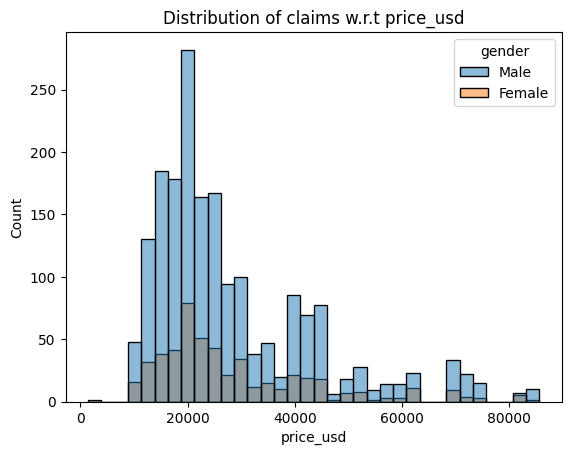

In [151]:
df = prep_data.query('claim_amount > 0').copy()
sns\
    .histplot(
        data=df,
        x='price_usd',
        hue='gender')\
    .set_title('Distribution of claims w.r.t price_usd')

## Time series analysis

**what is the overall trend of value of claims per month?**
* looks there is annual seasonality. when the new year starts, claim_amount falls down, until the end of the year there is increasing trend.
* on 5th, 9th and 12th months, there is increase.

/tmp/ipykernel_175/1866924149.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


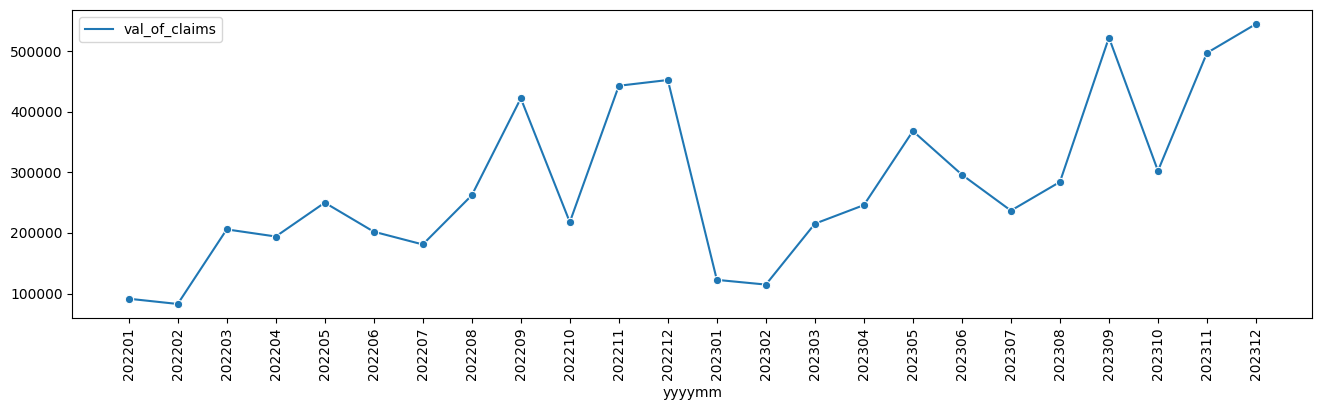

In [169]:
df = prep_data.query('claim_amount > 0').copy()

df = df.groupby('yyyymm').agg(
    val_of_claims=pd.NamedAgg('claim_amount', 'sum'))

plt.figure(figsize=(16, 4))
g = sns.lineplot(df, marker='o')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

plt.show()

In [170]:
from statsmodels.tsa.seasonal import STL

# stl = STL(co2, seasonal=13)
# res = stl.fit()
# fig = res.plot()


ModuleNotFoundError: No module named 'statsmodels'